# Depolarizing channel

In [66]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm_notebook as tqdm
import json
import copy

from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Tomography
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.ignis.verification.tomography import StateTomographyFitter

# Calibration
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, 
                                                CompleteMeasFitter, 
                                                MeasurementFilter)

from qiskit.tools.qi.qi import partial_trace

from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.jobstatus import JobStatus

In [22]:
# We use ibmqx2, but ibmq_vigo and ibmq_ourense work as well
IBMQ.load_account()
backend = IBMQ.get_provider().get_backend('ibmqx2')
simulator = Aer.get_backend('qasm_simulator')
vector_backend = Aer.get_backend('statevector_simulator')

In [60]:
from depolarizing_channel import depolarizing_channel_3q as depolarizing_channel

# The values for p
p_values = np.linspace(0, 1, 15)

# We create the quantum circuit
q = QuantumRegister(5, name='q')
c = ClassicalRegister(1, name='c')

# Index of the system qubit
system = 2

# Indices of the ancillary qubits
ancillae = [1, 3, 4]

# Prepare the qubit in a state that has coherence and different populations 
prepare_state = QuantumCircuit(q)
prepare_state.u3(np.pi/4, np.pi/4, 0, q[system])   

# We append the measurements for the tomography
tomo_circuits = []
for p in p_values:
    circ = prepare_state + depolarizing_channel(q, p)
    tomo_circuits += state_tomography_circuits(circ, q[system])

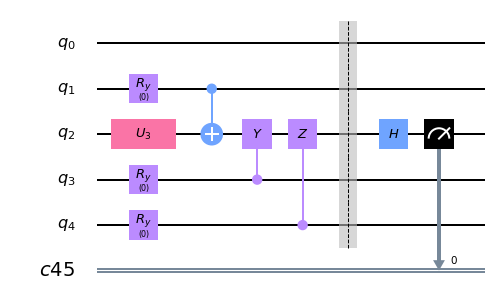

In [61]:
tomo_circuits[0].draw(output='mpl')

### Simulation

Text(0.5, 1.0, 'Depol. channel. Full tomo. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$')

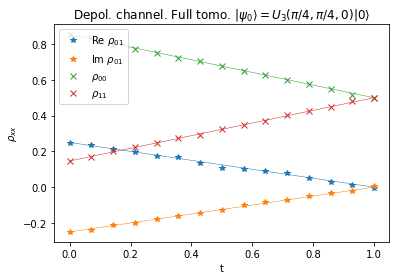

In [62]:
job = execute(tomo_circuits, backend=simulator, shots = 8192)

rhos = np.zeros((2,2,len(p_values)), dtype=complex)

for (i, p) in enumerate(p_values):
    test_result = copy.deepcopy(job.result())
    test_result.results = test_result.results[3*i:3*i+3]
    tomo_fitter = StateTomographyFitter(test_result, tomo_circuits[3*i:3*i+3])
    rhos[:,:,i] = tomo_fitter.fit()

plt.plot(p_values, np.real(rhos[0,1,:]),"C0*", label='Re $\\rho_{01}$')
plt.plot(p_values, np.imag(rhos[0,1,:]),"C1*", label='Im $\\rho_{01}$')
plt.plot(p_values, np.real(rhos[0,0,:]),"C2x", label='$\\rho_{00}$')
plt.plot(p_values, np.real(rhos[1,1,:]),"C3x", label='$\\rho_{11}$')

rho0 = partial_trace(execute(prepare_state, vector_backend).result().get_statevector(), [0,1,3,4])

plt.plot(p_values, np.real(rho0[0,1])*(1-p_values), "C0", linewidth=.5)
plt.plot(p_values, np.imag(rho0[0,1])*(1-p_values), "C1", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[0,0])*(1-p_values), "C2", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[1,1])*(1-p_values), "C3", linewidth=.5)

plt.xlabel('t')
plt.ylabel('$\\rho_{xx}$')
plt.legend();

plt.title("Depol. channel. Full tomo. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$")

### Execution on the real device

In [72]:
# Run the calibration job
cal_circuits, state_labels = complete_meas_cal([system], q, c)
calibration_job = execute(cal_circuits, backend, shots=8192)

job = execute(tomo_circuits, backend, shots=8192)

experiment_data = [{
    "backend": backend.name(),
    "calibration": calibration_job.job_id(),
    "description": "Circuits for tomographic reconstruction of the depolarizing channel",
    "jobs": [{'jobid': job.job_id(),
              'description': '3 tomography circuits for each value of p',
              'metadata': {'p_values': list(p_values)}
             }]
    }]

filename = 'depolarizing_channel_{}.json'.format(
            datetime.now().strftime(("%Y_%m_%d-%H_%M")))

with open(filename,'w') as file:
    json.dump(experiment_data, file)

### Monitor the job status

In [80]:
jobs = []
for experiment in experiment_data:
    backend = IBMQ.get_provider().get_backend(experiment['backend'])
    jobs.append(backend.retrieve_job(experiment['calibration']))
    
    for job in experiment['jobs']:
        jobs.append(backend.retrieve_job(job['jobid']))

In [81]:
for job in jobs:
     job_monitor(job)

Job Status: job has successfully run
Job Status: job has successfully run


### Analysis of the results

In [79]:
filename = "depolarizing_channel_2019_10_11-11_11.json"

with open(filename, 'r') as file:
    experiment_data = json.load(file)

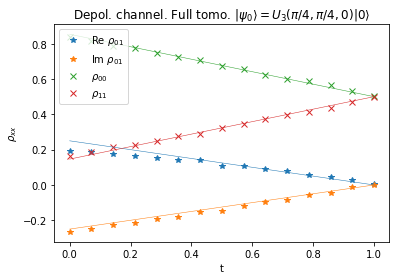

In [82]:
backend = IBMQ.get_provider().get_backend(experiment_data[0]['backend'])
calibration_job = backend.retrieve_job(experiment_data[0]['calibration'])
meas_fitter = CompleteMeasFitter(calibration_job.result(), state_labels)
meas_filter = meas_fitter.filter

p_values = np.array(experiment_data[0]['jobs'][0]['metadata']['p_values'])

job = backend.retrieve_job(experiment_data[0]['jobs'][0]['jobid'])

result = job.result()
result2 = meas_filter.apply(result)

rhos = np.zeros((2,2,len(p_values)), dtype=complex)

for (i, p) in enumerate(p_values):
    test_result = copy.deepcopy(result)
    test_result.results = test_result.results[3*i:3*i+3]
    tomo_fitter = StateTomographyFitter(test_result, tomo_circuits[3*i:3*i+3])
    rhos[:,:,i] = tomo_fitter.fit()

plt.plot(p_values, np.real(rhos[0,1,:]),"C0*", label='Re $\\rho_{01}$')
plt.plot(p_values, np.imag(rhos[0,1,:]),"C1*", label='Im $\\rho_{01}$')
plt.plot(p_values, np.real(rhos[0,0,:]),"C2x", label='$\\rho_{00}$')
plt.plot(p_values, np.real(rhos[1,1,:]),"C3x", label='$\\rho_{11}$')

vector_backend = Aer.get_backend('statevector_simulator')
rho0 = partial_trace(execute(prepare_state, vector_backend).result().get_statevector(), [0,1,3,4])

plt.plot(p_values, np.real(rho0[0,1])*(1-p_values), "C0", linewidth=.5)
plt.plot(p_values, np.imag(rho0[0,1])*(1-p_values), "C1", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[0,0])*(1-p_values), "C2", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[1,1])*(1-p_values), "C3", linewidth=.5)

plt.xlabel('t')
plt.ylabel('$\\rho_{xx}$')
plt.legend();

plt.title("Depol. channel. Full tomo. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$");